In [1]:
# https://pypi.org/project/yfinance/
import yfinance as yf
import pandas as pd
import numpy as np

pltr = yf.Ticker('PLTR')
info = pltr.info
# info
# shares

# https://finance.yahoo.com/quote/PLTR/key-statistics?p=PLTR
# sharesOutstanding - Shares outstanding is taken from the most recently filed quarterly or annual report
# impliedSharesOutstanding = info['impliedSharesOutstanding']

# sharesPercentSharesOut = info['sharesPercentSharesOut']

# volume = info['volume']
# regularMarketVolume = info['regularMarketVolume']
# averageVolume = info['averageVolume']
# floatShares - the number of shares available for trading. 

# sharesShort = info['sharesShort']
# sharesShortPreviousMonthDate
# sharesShortPriorMonth
# dateShortInterest

# shortRatio # ??
# shortPercentOfFloat

# heldPercentInstitutions = info['heldPercentInstitutions']
# heldPercentInsiders = info['heldPercentInsiders']

# pltr.info
# parse contractSymbol date

def parse_contractSymbol(cs, rdate=False):
    #     cs = 'PLTR210108C00025000'
    ticker = cs [:-15]
    year = cs[-15:-13]
    month = cs[-13:-11]
    day = cs[-11:-9]
    instr_type = cs[-9]
    strike = float(cs[-8:])/1000
    
    if rdate == True:
        return date(2000+int(year), int(month), int(day))
    
    return (ticker, year, month, day, instr_type, strike)

from datetime import datetime
# datetime.datetime.now()
# current prices
now = datetime.now()
prices = {
    'LondonTime': now,
    'timestamp': datetime.timestamp(now),
    'ask': info['ask'],
    'bid': info['bid'],
    'mid': (info['ask'] + info['bid'])/2 
}
prices

{'LondonTime': datetime.datetime(2021, 1, 18, 13, 8, 45, 729126),
 'timestamp': 1610975325.729126,
 'ask': 25.92,
 'bid': 25.75,
 'mid': 25.835}

In [3]:
pltr.history(start="2020-01-01")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-09-30,10.000000,11.410000,9.110000,9.500000,335537500,0,0
2020-10-01,9.690000,10.100000,9.230000,9.460000,124297600,0,0
2020-10-02,9.060000,9.280000,8.940000,9.200000,55018300,0,0
2020-10-05,9.430000,9.490000,8.920000,9.030000,36316900,0,0
2020-10-06,9.040000,10.180000,8.900000,9.900000,90864000,0,0
...,...,...,...,...,...,...,...
2021-01-06,24.120001,24.459999,23.250000,23.540001,32732900,0,0
2021-01-07,24.020000,25.190001,23.670000,25.000000,32240000,0,0
2021-01-08,25.700001,26.440001,24.700001,25.200001,41313800,0,0


Shares Outstanding = [include those held by shareholders and company insiders.](https://www.investopedia.com/ask/answers/062315/what-difference-between-shares-outstanding-and-floating-stock.asp)

Float = [the number of shares available for trading](https://www.investopedia.com/ask/answers/062315/what-difference-between-shares-outstanding-and-floating-stock.asp)

In [4]:
# lets see what option chains tell us
index = ['sharesOutstanding', 'impliedSharesOutstanding', 'sharesPercentSharesOut', 
         'volume',
         'regularMarketVolume',
         'averageVolume',
         'floatShares',
         
         'sharesShort', 
         'sharesShortPreviousMonthDate',
         'sharesShortPriorMonth',
         'dateShortInterest',
         
         'shortRatio',
         'shortPercentOfFloat',
         
         'heldPercentInstitutions',
         'heldPercentInsiders'
        ]
df = pd.DataFrame([info[x] for x in index], index=index, columns=['PLTR'])

# shout = df['PLTR']['sharesOutstanding']
# # type(df['PLTR']['sharesOutstanding']) # numpy.int64

# print(f"{shout:,}") # 496,529,984

df.style.format("{:,.0f}") #!!!


,PLTR
sharesOutstanding,"496,529,984"
impliedSharesOutstanding,"1,587,520,000"
sharesPercentSharesOut,0
volume,"31,853,876"
regularMarketVolume,"31,853,876"
averageVolume,"57,726,917"
floatShares,"1,036,011,961"
sharesShort,"70,602,979"
sharesShortPreviousMonthDate,"1,605,225,600"
sharesShortPriorMonth,"34,273,587"


yahoo data on PLTR's shares makes no sense

[latest report](https://www.sec.gov/cgi-bin/viewer?action=view&cik=1321655&accession_number=0001193125-20-292177&xbrl_type=v#) gives 1,726,685,755 of Common stock, shares outstanding

In [2]:
# let's see what option chains are telling us
expirations = pltr.options # Tuple
expiration = expirations[0]
print
chain = pltr.option_chain(expiration)

# CALLS
# type(chain.calls) # DataFrame
calls = chain.calls 


# PUTS
# type(chain.calls) # DataFrame
puts = chain.puts 

# np.array(calls['volume'])
# np.array(calls['openInterest'])
# calls[20:40]['lastPrice'].pct_change()
# calls.loc[20:40, ~calls.columns.isin(['change'])]


In [3]:
# save all calls and puts to csv

columns = ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency']

all_calls = pd.DataFrame([], columns=columns)
all_puts = pd.DataFrame([], columns=columns)
for exp in expirations:
    chain = pltr.option_chain(exp)
    all_calls = pd.concat([all_calls, chain.calls], axis=0, ignore_index=True)
    all_puts = pd.concat([all_puts, chain.puts], axis=0, ignore_index=True)
    
print(all_calls.shape)
print(all_puts.shape)

# pure
def add_curr_price(df_, prices):
    df = df_.copy()
    df['undPriceAsk'] = prices['ask']
    df['undPriceBid'] = prices['bid']
    df['undPriceMid'] = prices['mid']
    df['undPriceLondonTime'] = prices['LondonTime']
    df['undPriceTimestamp'] = prices['timestamp']
    df['mtime'] = datetime.timestamp(datetime.now())
    return df


calls_new = add_curr_price(all_calls, prices)
puts_new = add_curr_price(all_puts, prices)
calls_new.to_csv(f"D:\\code\\test\\csv\\pltr\\{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR all calls.csv")
puts_new.to_csv(f"D:\\code\\test\\csv\\pltr\\{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR all puts.csv")
# calls_new.to_csv(f"~/Desktop/code/mamacita/csv/pltr/{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR all calls.csv")
# puts_new.to_csv(f"~/Desktop/code/mamacita/csv/pltr/{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR all puts.csv")

(387, 14)
(377, 14)


In [44]:

# calls
# https://www.tutorialspoint.com/How-to-get-min-seconds-and-milliseconds-from-datetime-now-in-Python
# filename = '~/Desktop/' + datetime.now().strftime('%y-%m-%d %H:%M:%S') + ' PLTR ' + "{:.2f}".format(prices['mid']) + ' calls.csv'
# filename = '~/Desktop/' + datetime.now().strftime('%y-%m-%d %H-%M-%S') + ' PLTR ' + ' calls.csv'
filename = f"~/Desktop/pltr/{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR calls.csv"
filename_win = f"D:\\code\\test\\csv\\{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR calls.csv"
calls.to_csv(filename_win)

In [38]:
filename = f"~/Desktop/pltr/{datetime.now().strftime('%y-%m-%d %H.%M.%S')} PLTR puts.csv"
puts.to_csv(filename)

In [49]:
# extract strike & volume & openInterests for mock data
df = calls.loc[:, ['contractSymbol', 'strike', 'volume', 'openInterest']]

# let's prune and leave strikes within +- 25% of current mktprice 
new = df.copy().loc[
    (df['strike'] < prices['mid'] * 1.25) &
    (df['strike'] > prices['mid'] * .75)
    ]
new


# let's check where volume > openInterest
new.loc[:, 'volume'] = new['volume'] > new['openInterest']
# new
# 7	    PLTR210108C00024000	24.0	True	4250
# 18	PLTR210108C00024500	24.5	True	6747
# 19	PLTR210108C00025000	25.0	True	14358
# 20	PLTR210108C00025500	25.5	True	6780
# 21	PLTR210108C00026000	26.0	True	11045

,contractSymbol,strike,volume,openInterest
8,PLTR210108C00019500,19.5,False,41
9,PLTR210108C00020000,20.0,False,235
10,PLTR210108C00020500,20.5,False,88
11,PLTR210108C00021000,21.0,False,160
12,PLTR210108C00021500,21.5,False,196
13,PLTR210108C00022000,22.0,False,1088
14,PLTR210108C00022500,22.5,False,548
15,PLTR210108C00023000,23.0,False,2664
16,PLTR210108C00023500,23.5,False,3796
17,PLTR210108C00024000,24.0,True,4250


('PLTR', '21', '01', '08', 'C', 25.0)

In [27]:
# reduce each option chain into ((year, month, day), strike, openInterest) for further plotting


def max_openInterest(option_chain, rtstmp=False):
    y = option_chain.loc[option_chain.sort_values(by=['openInterest'], ascending=False).openInterest.idxmax()] # Series
    ticker, year, month, day, instr_type, strike = parse_contractSymbol(y['contractSymbol'])
#     if rtstmp:
#         return (datetime., y['strike'], y['openInterest'])
    return (f"20{year}-{month}-{day}", y['strike'], y['openInterest'])

max_openInterest(calls)

('2021-01-15', 30.0, 80195)

In [41]:
# pick one the most interesting contract symbol
def max_interest_by(df, col='openInterest'):
    return df.loc[df.sort_values(by=[col], ascending=False)[col].idxmax()] # Series

max_interest_by(calls, col='openInterest')

contractSymbol       PLTR210115C00030000
lastTradeDate        2021-01-12 14:48:10
strike                         30.000000
lastPrice                       0.080000
bid                             0.070000
ask                             0.080000
change                         -0.010000
percentChange                 -11.111116
volume                       3778.000000
openInterest                       80195
impliedVolatility               0.875001
inTheMoney                         False
contractSize                     REGULAR
currency                             USD
Name: 38, dtype: object

In [7]:
# ok, I'll take largest OpenInterest strikes (y axis) and plot against time (x axis)
# this will represent what market thinks the underlying price will be.

# first of all, lets get all expirations into our dataframe
# I

calls_all_chains = [pltr.option_chain(exp).calls for exp in expirations]
len(calls_all_chains)

# construct df
data = [max_openInterest(chain) for chain in calls_all_chains]
df = pd.DataFrame(data, columns=['Expiration Date', 'Strike', 'Open Interest'])
df.index = df['Expiration Date']
# [max_openInterest(chain) for chain in calls_all_chains]
df

,Expiration Date,Strike,Open Interest
Expiration Date,,,
2021-01-08,2021-01-08,25.0,14358
2021-01-15,2021-01-15,30.0,69927
2021-01-22,2021-01-22,30.0,7097
2021-01-29,2021-01-29,30.0,6332
2021-02-05,2021-02-05,30.0,2009
2021-02-12,2021-02-12,25.0,428
2021-02-19,2021-02-19,35.0,44062
2021-03-19,2021-03-19,26.0,39038
2021-05-21,2021-05-21,40.0,19795


<AxesSubplot:xlabel='Expiration Date'>

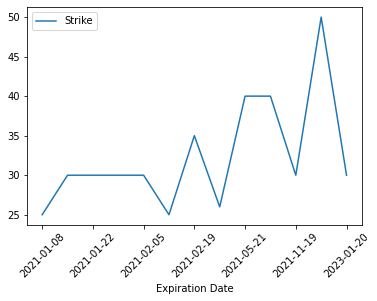

In [11]:
# plot
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
df.loc[:, ['Strike', 'Expiration Date']].plot(rot=45) # cool!